In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()

In [4]:
len(words)

32033

In [5]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
chars = sorted(list(set(''.join(words))))

# util 

In [7]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [8]:
stoi = {s: i for i, s in itos.items()}

# train a bigram nn

## prepare data

In [9]:
xs, ys = [], []
for w in words[:]:
    w2 = '.' + w + '.'
    for ch1, ch2 in zip(w2, w2[1:]):
        if ch1 != '.' and ch1 != 'a':
            # continue
            pass
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

In [10]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [11]:
xs, ys

(tensor([ 0,  5, 13,  ..., 25, 26, 24]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [12]:
xs.shape, ys.shape

(torch.Size([228146]), torch.Size([228146]))

## build a simple nn

In [120]:
losses = {}
for lr in [0.01, 0.1, 1.0]:
    for i, batch_size in enumerate([2**2, 2**7, 2**12]):
        label = f'{lr}-{batch_size}'
        losses[label] = []
        # w = torch.randn(len(itos), len(itos), requires_grad=True)
        w = torch.zeros((len(itos), len(itos)), requires_grad=True)

        for i in tqdm(range(2_000_000)):
            batch = torch.randint(0, xs.shape[0], (batch_size,))
            xb = xs[batch]
            yb = ys[batch]
            # forward
            xenc = F.one_hot(xb, num_classes=len(itos)).float()
            logits = xenc @ w
            counts = logits.exp()
            probs = counts / counts.sum(1, keepdim=True)
            loss = -probs[torch.arange(yb.shape[0]), yb].log().mean()
            losses[label].append(loss.item())

            # backword
            w.grad = None
            loss.backward()

            # update
            w.data += -lr * w.grad

100%|███████████████████████████████████████████████████████| 2000000/2000000 [34:44<00:00, 959.32it/s]


# Q1: batch size vs loss

In [133]:
len(x)

180

In [134]:
x

tensor([ 204999.5000,  214999.5000,  224999.5000,  234999.5000,  244999.5000,
         254999.5000,  264999.5000,  274999.5000,  284999.5000,  294999.5000,
         304999.4688,  314999.5000,  324999.5000,  334999.5000,  344999.5000,
         354999.4688,  364999.5000,  374999.5312,  384999.5000,  394999.5000,
         404999.5000,  414999.5000,  424999.5000,  434999.5000,  444999.4688,
         454999.5000,  464999.5312,  474999.5000,  484999.5312,  494999.4375,
         504999.4688,  514999.5000,  524999.5000,  534999.5625,  544999.5000,
         554999.5000,  564999.5000,  574999.5000,  584999.5000,  594999.5000,
         604999.5000,  614999.5625,  624999.5000,  634999.5000,  644999.5000,
         654999.5000,  664999.5000,  674999.5000,  684999.5000,  694999.5000,
         704999.5000,  714999.5000,  724999.5000,  734999.5000,  744999.5000,
         754999.5625,  764999.5000,  774999.5625,  784999.5000,  794999.5000,
         804999.5000,  814999.5000,  824999.5000,  834999.5000, 

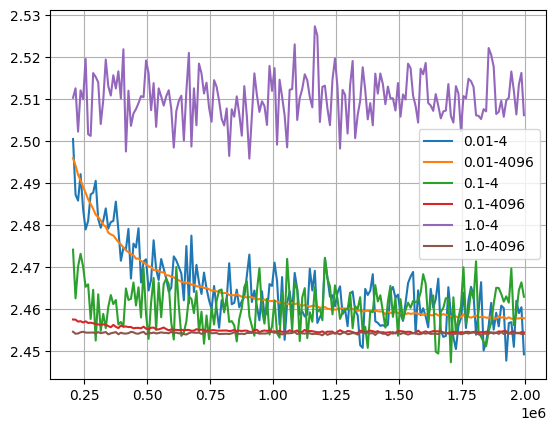

In [131]:
for lr in [0.01, 0.1, 1.0]: #, 10.0]:
    for i, batch_size in enumerate([2**2, 2**12]):
        label = f'{lr}-{batch_size}'
        lossi = losses[label]
        x = torch.arange(len(lossi)).view(-1, 10_000).float().mean(1)[20:]
        data = torch.tensor(lossi).view(-1, 10_000).mean(1)[20:]
        if i == 0:
            line, = plt.plot(x, data, label=label)
        else:
            line, = plt.plot(x, data, label=label)
            # plt.plot(torch.tensor(lossi).view(-1, 500).mean(1), color=line.get_color())
plt.grid()
plt.legend()
plt.show()

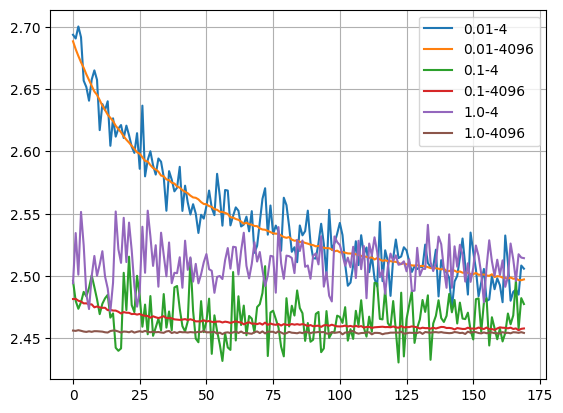

In [119]:
for lr in [0.01, 0.1, 1.0]: #, 10.0]:
    for i, batch_size in enumerate([2**2, 2**12]):
        label = f'{lr}-{batch_size}'
        lossi = losses[label]
        data = torch.tensor(lossi).view(-1, 1_000).mean(1)[30:]
        if i == 0:
            line, = plt.plot(data, label=label)
        else:
            line, = plt.plot(data, label=label)
            # plt.plot(torch.tensor(lossi).view(-1, 500).mean(1), color=line.get_color())
plt.grid()
plt.legend()
plt.show()

## Q2: Does the original P minimize the loss of the nn?

In [112]:
w = torch.zeros_like(P, requires_grad=True)

In [113]:
w.data[0] = P[0]

In [114]:
w.data[1] = P[1]

In [115]:
losses = []
# w = P.clone().detach().requires_grad_(True)

for i in tqdm(range(100)):
    # forward
    xenc = F.one_hot(xs, num_classes=len(itos)).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean()
    losses.append(loss.item())

    # backword
    w.grad = None
    loss.backward()
    break
    
    # update
    w.data += -50.0 * w.grad

  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]


In [116]:
w.grad[0:2,]

tensor([[ 0.0050, -0.0136, -0.0005, -0.0015, -0.0021, -0.0015,  0.0032,  0.0022,
          0.0013,  0.0025, -0.0052, -0.0075, -0.0016, -0.0057,  0.0002,  0.0033,
          0.0028,  0.0046, -0.0019, -0.0037, -0.0005,  0.0047,  0.0034,  0.0037,
          0.0044,  0.0027,  0.0011],
        [-0.0227,  0.0029,  0.0030,  0.0033,  0.0009,  0.0024,  0.0047,  0.0046,
         -0.0045, -0.0017,  0.0046,  0.0029, -0.0054, -0.0016, -0.0176,  0.0050,
          0.0049,  0.0050, -0.0085,  0.0006,  0.0024,  0.0037,  0.0018,  0.0046,
          0.0045, -0.0034,  0.0035]])

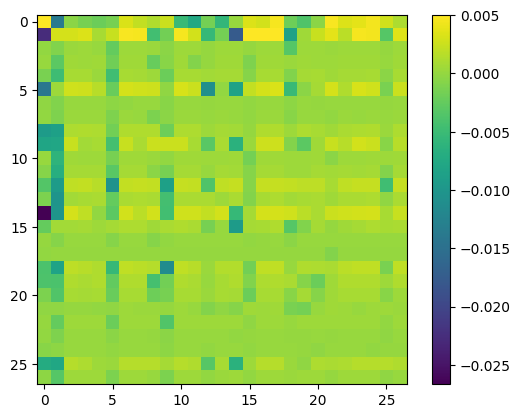

In [118]:
# plt.imshow(w.grad[0:2])
plt.imshow(w.grad)
plt.colorbar()
plt.show()

## Q3: What kind of loss does P minimize?

In [119]:
losses = []
w = torch.zeros((len(itos), len(itos)), requires_grad=True)

for i in tqdm(range(100)):
    # forward
    xenc = F.one_hot(xs, num_classes=len(itos)).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean()
    losses.append(loss.item())

    # backword
    w.grad = None
    loss.backward()
    break
    
    # update
    w.data += -50.0 * w.grad

  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]
